#  Assignment

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

### 1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.

<h2> 3.6 Featurizing text data with tfidf  </h2>

In [62]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
from tqdm import tqdm
from collections import Counter, defaultdict
from scipy.sparse import hstack
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import spacy
from lightgbm import LGBMClassifier 

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [4]:
df1 = dfnlp
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# mregin df1 and df2

data=pd.merge(df1,df2,how='inner',on='id',) 
y_true=data["is_duplicate"]
data=data.drop("is_duplicate",axis=1)


<h2>  Random train test split( 70:30) </h2>

Doing it before vectorising Question1 and Question2 to avoid data leakage

Taking only 100K of total datapoints because of computational strain

In [5]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true,test_size=0.3)

In [6]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 31)
Number of data points in test data : (121287, 31)


In [7]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


### TfIDF of Question1 and Question2

Doing this after the split to avoid data leakage

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
train_questions = (X_train['question1']) + (X_train['question2'])
train_questions =train_questions.apply(lambda x: str(x)) 

test_questions = (X_test['question1']) + (X_test['question2'])
test_questions=test_questions.apply(lambda x: str(x))

tfidf = TfidfVectorizer(lowercase=False,)
train_tfidf_questions=tfidf.fit_transform(train_questions)
test_tfidf_questions=tfidf.transform(test_questions)


In [9]:
train_final_features = hstack((train_tfidf_questions,X_train.drop(['id','qid1','qid2','question1','question2'],axis=1)))
test_final_features = hstack((test_tfidf_questions,X_test.drop(['id','qid1','qid2','question1','question2'],axis=1)))


In [10]:
train_final_features.shape,test_final_features.shape

((283003, 73906), (121287, 73906))

## Machine learning models

In [63]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8861836643485206


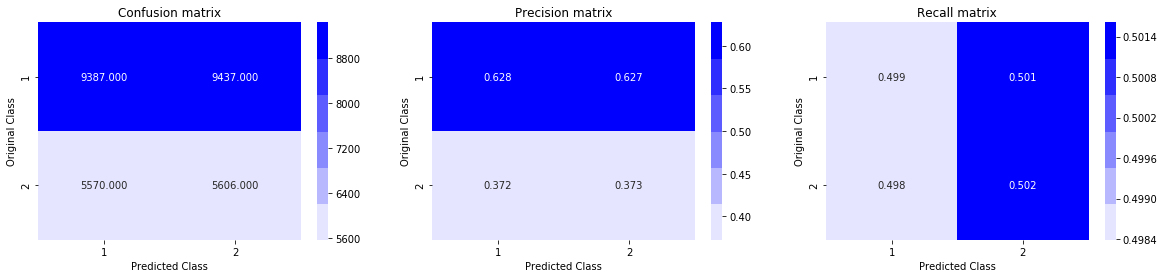

In [27]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.38840477731593986
For values of alpha =  0.0001 The log loss is: 0.39360993477465694
For values of alpha =  0.001 The log loss is: 0.42912329650555026
For values of alpha =  0.01 The log loss is: 0.44329131754336976
For values of alpha =  0.1 The log loss is: 0.46237898859229515
For values of alpha =  1 The log loss is: 0.4934267929205486
For values of alpha =  10 The log loss is: 0.546343318580212


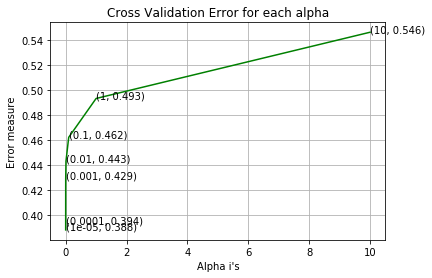

For values of best alpha =  1e-05 The train log loss is: 0.38513688366523374
For values of best alpha =  1e-05 The test log loss is: 0.38840477731593986
Total number of data points : 121287


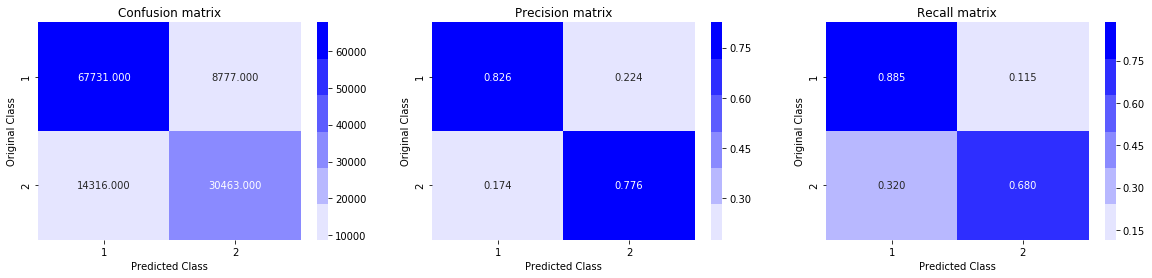

In [36]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_final_features, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_final_features, y_train)
    predict_y = sig_clf.predict_proba(test_final_features)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_final_features, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_final_features, y_train)

predict_y = sig_clf.predict_proba(train_final_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_final_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.39591530572376715
For values of alpha =  0.0001 The log loss is: 0.40844126641409034
For values of alpha =  0.001 The log loss is: 0.43754415094079085
For values of alpha =  0.01 The log loss is: 0.44808747999311643
For values of alpha =  0.1 The log loss is: 0.4635168350686396
For values of alpha =  1 The log loss is: 0.48561672909575904
For values of alpha =  10 The log loss is: 0.5444801761576894


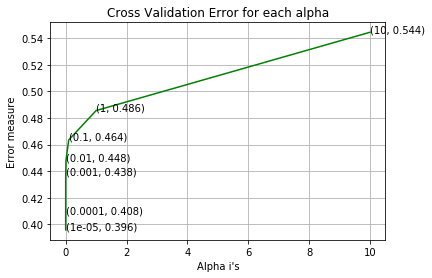

For values of best alpha =  1e-05 The train log loss is: 0.39301733371888375
For values of best alpha =  1e-05 The test log loss is: 0.39591530572376715
Total number of data points : 121287


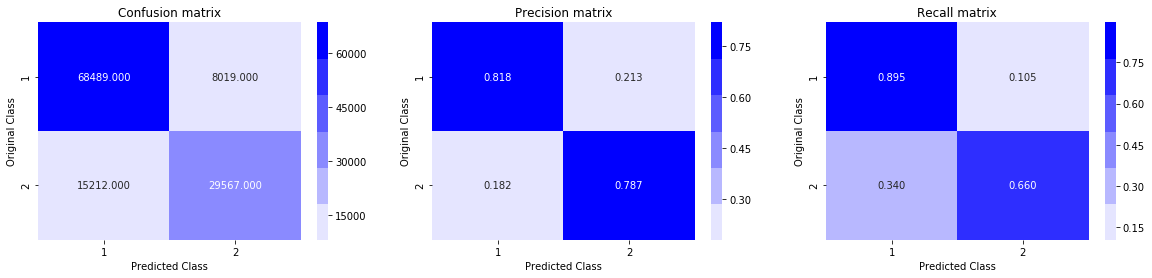

In [37]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_final_features, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_final_features, y_train)
    predict_y = sig_clf.predict_proba(test_final_features)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_final_features, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_final_features, y_train)

predict_y = sig_clf.predict_proba(train_final_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_final_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### 2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

## 4.6 LGBM (*altenative of XGBoost* )

In [54]:
from lightgbm import LGBMClassifier

param={'num_leaves': [25,30,40,50,60], 'learning_rate': [0.1,0.2,0.3], 'n_estimators': [50,75,100,150,200]}

lgbm = LGBMClassifier( boosting_type='gbdt', class_weight='balanced', objective='binary', n_jobs=1)
rscv=RandomizedSearchCV(estimator=lgbm, param_distributions=param, scoring='neg_log_loss', n_jobs=-2, return_train_score=True,)
rscv.fit(train_final_features,y_train)

result=pd.DataFrame({"param":rscv.cv_results_["params"], "train_log_loss":(-rscv.cv_results_["mean_train_score"]),"cv_log_los":(-rscv.cv_results_["mean_test_score"])})
result

,param,train_log_loss,cv_log_los
0,"{'num_leaves': 40, 'n_estimators': 50, 'learni...",0.306635,0.330089
1,"{'num_leaves': 60, 'n_estimators': 150, 'learn...",0.285764,0.316318
2,"{'num_leaves': 60, 'n_estimators': 100, 'learn...",0.302621,0.323599
3,"{'num_leaves': 25, 'n_estimators': 75, 'learni...",0.319722,0.332139
4,"{'num_leaves': 50, 'n_estimators': 100, 'learn...",0.264356,0.314788
5,"{'num_leaves': 60, 'n_estimators': 75, 'learni...",0.314702,0.330281
6,"{'num_leaves': 40, 'n_estimators': 200, 'learn...",0.292058,0.318372
7,"{'num_leaves': 30, 'n_estimators': 75, 'learni...",0.313913,0.329016
8,"{'num_leaves': 40, 'n_estimators': 50, 'learni...",0.343494,0.349954
9,"{'num_leaves': 25, 'n_estimators': 150, 'learn...",0.283210,0.323187


In [65]:
# Best Scores
print("best score on traing dataset:", -(rscv.best_score_))
print("best hyperparameter:",rscv.best_params_)

y_train_pred=rscv.predict_proba(train_final_features)
predict_y=rscv.predict_proba(test_final_features)
print("\nThe train log loss is:",log_loss(y_train, y_train_pred,))
print("The test log loss is:",log_loss(y_test, predict_y, ))

best score on traing dataset: 0.31478816906978896
best hyperparameter: {'num_leaves': 50, 'n_estimators': 100, 'learning_rate': 0.3}

The train log loss is: 0.27728475542021147
The test log loss is: 0.3139864359999996


Total number of data points : 121287


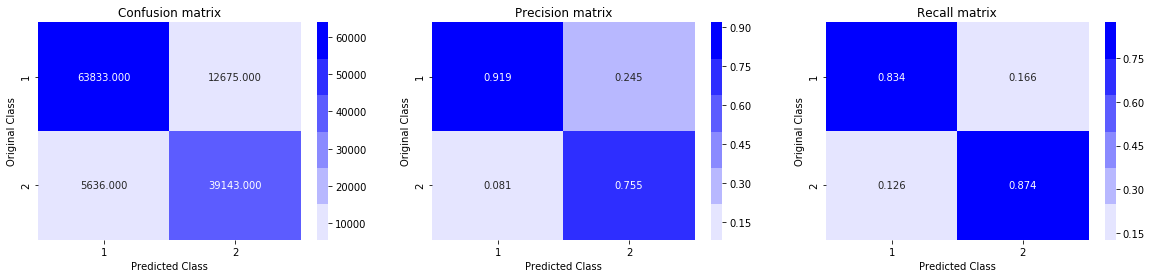

In [66]:
# Best Hyperparameter Confusion matrix
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)